In [9]:
import numpy as np
from contextualized.dags.graph_utils import *
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def project_to_dag_search_old(w):
    if is_dag(w):
        return w, 0.0

    w_dag = w.copy()
    w_dag = break_symmetry(w_dag)

    vals = sorted(list(set(np.abs(w_dag).flatten())))
    low = 0
    high = len(vals) - 1

    def binary_search(arr, low, high, w):  # low and high are indices
        # Check base case
        if high == low:
            return high
        if high > low:
            mid = (high + low) // 2
            if mid == 0:
                return mid
            result = trim_params(w, arr[mid])
            if is_dag(result):
                result2 = trim_params(w, arr[mid - 1])
                if is_dag(result2):  # middle value is too high.  go lower.
                    return binary_search(arr, low, mid - 1, w)
                else:
                    return mid  # found it
            else:  # middle value is too low.  go higher.
                return binary_search(arr, mid + 1, high, w)
        else:
            # Element is not present in the array
            print("this should be impossible")
            return -1

    idx = binary_search(vals, low, high, w_dag) + 1
    thresh = vals[idx]
    w_dag = trim_params(w_dag, thresh)

    # Now add back in edges with weights smaller than the thresh that don't violate DAG-ness.
    # want a list of edges (i, j) with weight in decreasing order.
    all_vals = np.abs(w_dag).flatten()
    idxs_sorted = reversed(np.argsort(all_vals))
    for idx in idxs_sorted:
        i = idx // w_dag.shape[1]
        j = idx % w_dag.shape[1]
        if np.abs(w[i][j]) > thresh:  # already retained
            continue
        w_dag[i][j] = w[i][j]
        if not is_dag(w_dag):
            w_dag[i][j] = 0.0

    assert is_dag(w_dag)
    return w_dag

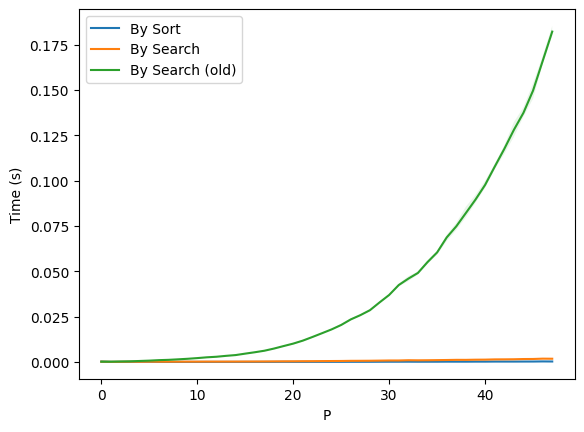

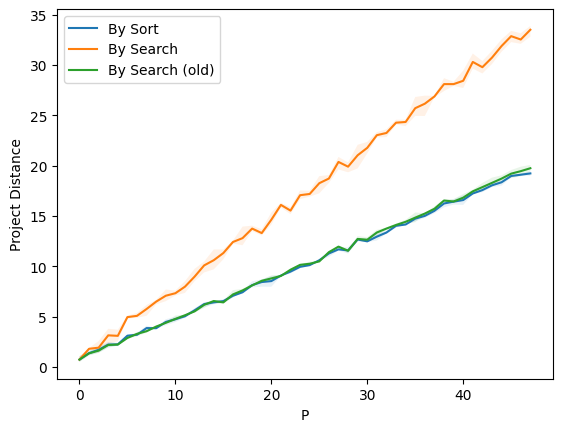

In [11]:
sort_times = []
search_times = []
search_old_times = []

sort_dists = []
search_dists = []
search_old_dists = []

for n in range(2, 50):
    my_sort_times = []
    my_search_times = []
    my_search_old_times = []
    my_search_dists = []
    my_sort_dists = []
    my_search_old_dists = [] 
    for k in range(3):
        w = np.random.uniform(-1, 1, size=(n,n))
        t = time.time()
        w_dag = project_to_dag_search(w)
        my_search_times.append(time.time() - t)
        my_search_dists.append(np.linalg.norm(w_dag - w))
        
        t = time.time()
        w_dag = project_to_dag_torch(w)
        my_sort_times.append(time.time() - t)
        my_sort_dists.append(np.linalg.norm(w_dag - w))
        
        t = time.time()
        w_dag = project_to_dag_search_old(w)
        my_search_old_times.append(time.time() - t)
        my_search_old_dists.append(np.linalg.norm(w_dag - w))
        
    sort_times.append(my_sort_times)
    search_times.append(my_search_times)
    sort_dists.append(my_sort_dists)
    search_dists.append(my_search_dists)
    search_old_times.append(my_search_old_times)
    search_old_dists.append(my_search_old_dists)
    

def plot_results(results, label):
    results = np.array(results)
    plt.plot(np.mean(results, axis=1), label=label)
    plt.fill_between(range(len(results)),
                     np.percentile(results, 2.5, axis=1),
                     np.percentile(results, 97.5, axis=1),
                    alpha=0.1)
plot_results(sort_times, "By Sort")
plot_results(search_times, "By Search")
plot_results(search_old_times, "By Search (old)")
plt.xlabel("P")
plt.ylabel("Time (s)")
plt.legend()

plt.figure()
plot_results(sort_dists, "By Sort")
plot_results(search_dists, "By Search")
plot_results(search_old_dists, "By Search (old)")
plt.xlabel("P")
plt.ylabel("Project Distance")
plt.legend()